# face_detection.ipynb
__Author:__ Matthew Lesko-Krleza<br>
__Course:__ ECSE 415<br>
__Assignment:__ Assignment #4 Face Detection<br>
__Due Date:__ November 22nd 2018

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# From Tutorial #8
""" Edge Haar Features """
def edge_features(size):
    """
    Create Haar edge features.
    
    @param size: size of Haar filter
                    @pre even integer >= 2
    
    @return list of edge Haar filters
    """
    edge1 = np.zeros((size, size))
    edge2 = np.zeros((size, size))
    idx = int(size/2)
    edge1[:, idx:] = 1
    edge2[:idx, :] = 1
    return edge1, edge2

""" Line Haar Features """
def line_features(size):
    """
    Create Haar line features.
    
    @param size: size of Haar filter
                    @pre integer multiple of 3 & >= 3
    
    @return list of line Haar filters
    """
    line1 = np.zeros((size, size))
    line2 = np.zeros((size, size))
    idx = int(size/3)
    line1[:, :idx] = 1
    line1[:, -idx:] = 1
    line2[:idx, :] = 1
    line2[-idx:, :] = 1
    return line1, line2

""" Four-Rectangle Features """
def four_rect_features(size):
    """
    Create Haar four-rectangle features.
    
    @param size: size of Haar filter
                    @pre even integer & >= 2
    
    @return four-rectangle feature
    """
    rect = np.zeros((size, size))
    idx = int(size/2)
    rect[:idx, :idx]  = 1
    rect[-idx:, -idx:] = 1
    return rect

#### Question 1. Data Acquisition

In [34]:
DIRECTORY = './dataset/'
SIZE = (100, 100)

evans, hemsw, johan = [], [], []
group = None
images = os.listdir(DIRECTORY)

for i in range(len(images)):
    name = images[i]
    img = cv2.imread(DIRECTORY + name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if 'evans' in name:
        img = cv2.resize(img, SIZE)
        evans.append(img)
    elif 'hemsworth' in name:
        img = cv2.resize(img, SIZE)
        hemsw.append(img)
    elif 'johansson' in name:
        img = cv2.resize(img, SIZE)
        johan.append(img)
    elif 'group' in name:
        group = img
    else:
        print('Wrong image name')

Figure 1. Training Images:


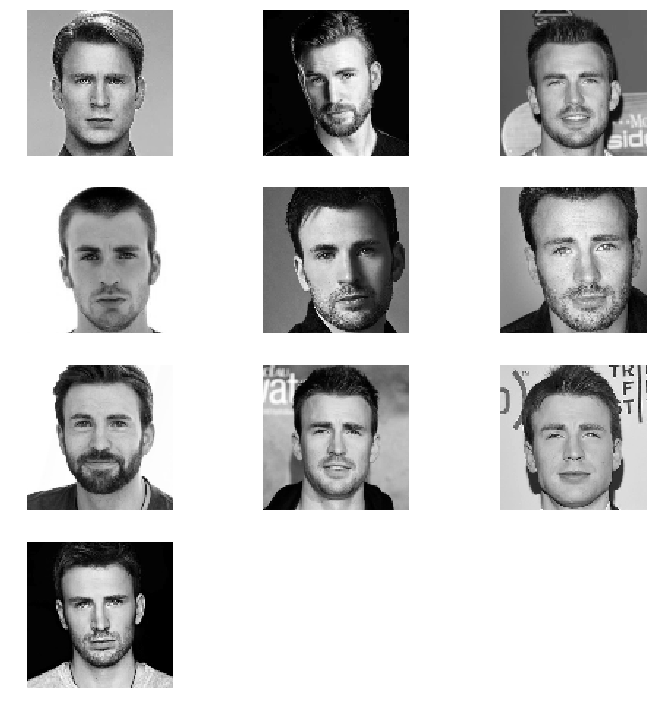

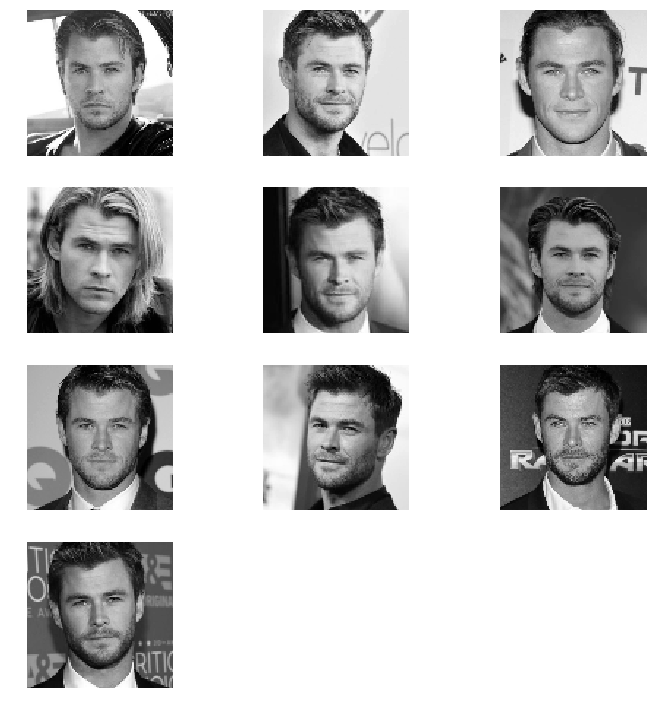

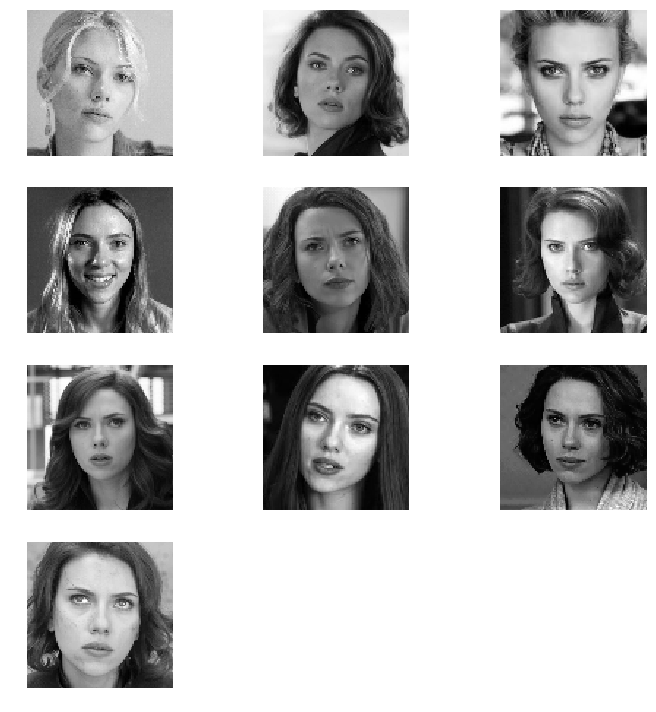

Figure 2. Test Image:


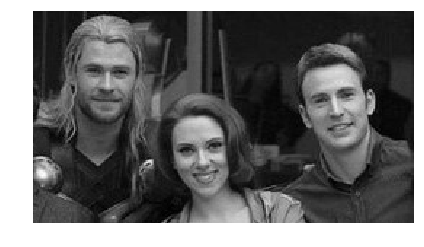

In [35]:
print('Figure 1. Training Images:')
plt.figure(figsize=(10,10))
for i in range(len(evans)):
    plt.subplot(4, 3, i + 1)
    plt.imshow(evans[i], "gray")
    plt.axis('off')
    plt.tight_layout()
plt.figure(figsize=(10,10))
for i in range(len(hemsw)):
    plt.subplot(4, 3, i + 1)
    plt.imshow(hemsw[i], "gray")
    plt.axis('off')
    plt.tight_layout()
plt.figure(figsize=(10,10))
for i in range(len(johan)):
    plt.subplot(4, 3, i + 1)
    plt.imshow(johan[i], "gray")
    plt.axis('off')
    plt.tight_layout()
plt.show()

print('Figure 2. Test Image:')
plt.subplot(1, 1, 1)
plt.imshow(group, "gray")
plt.axis('off')
plt.tight_layout()
plt.show()

I've chosen the group photo as seen in Figure 2, because the test faces are well illuminated and are facing towards the camera. I've chosen to use the 30 training images as seen in Figure 1, because the subjects' faces are well illuminated and facing towards the camera. There are a few training images that include a shadow on the subject's face. This would help create a more robust predictor for the respective faces. The training faces are also all of similar scale. I've set all the images to grayscale for simpler computation; there is only one dimensional variable to consider instead of 3.

I've also resized the training images to 100 x 100 pixels. This results in 10_000 dimensional vectors to be used, hence decreasing the initial face space size. Increasing the computation speed.

#### Question 2. Eigenvector Representation

In [98]:
# We desire a vector intensity representation of the images, hence we flatten the matrices
evans_flat = [v.flatten() for v in evans]
hemsw_flat = [v.flatten() for v in hemsw]
johan_flat = [v.flatten() for v in johan]

# Each column must represent one face, instead of one row representing one face
D = np.array([*evans_flat, *hemsw_flat, *johan_flat]).transpose()
N = len(D.transpose())
D_square = np.dot(D, D.transpose())
print('vt:\t', D[:,0].transpose().shape)
print('D:\t', D.shape)
print('Dt:\t', D.transpose().shape)
print('v:\t', D[:,0].shape)

variances = [1 / (N - 1) * np.dot(np.dot(v.transpose(), D_square), v) for v in D.transpose()]

vt:	 (10000,)
D:	 (10000, 30)
Dt:	 (30, 10000)
v:	 (10000,)


In [101]:
print(variances)

[2.5172413793103448, 3.2413793103448274, 2.8620689655172415, 4.0, 7.172413793103448, 5.1034482758620685, 4.068965517241379, 5.1034482758620685, 2.793103448275862, 3.9310344827586206, 6.1034482758620685, 6.689655172413793, 1.6206896551724137, 3.3448275862068964, 1.0, 5.344827586206897, 4.758620689655173, 0.3793103448275862, 3.5517241379310343, 2.3448275862068964, 8.068965517241379, 6.655172413793103, 4.448275862068965, 1.5517241379310345, 1.0, 6.620689655172414, 8.448275862068966, 2.8275862068965516, 3.3793103448275863, 0.8275862068965517]


In [ ]:
w_eig, v_eig = np.linalg.eig(D_square)